# Inicialização

In [22]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  torch.optim as optim
import  psutil
import  os
import  time
import  joblib
import  warnings
import  pandas as pd
import  seaborn as sns
import  snap7
import  ctypes
import  struct
import  numpy as np
import  matplotlib.pyplot as plt


import imodelsx
from imodelsx import KANClassifier

from    torch.utils.data import DataLoader, TensorDataset
from    sklearn.model_selection import train_test_split
from    sklearn.metrics import confusion_matrix, classification_report
from    sklearn.ensemble import RandomForestClassifier
from    sklearn.preprocessing import LabelEncoder
from    sklearn.preprocessing import OneHotEncoder
from    sklearn.model_selection import GridSearchCV
from    sklearn.preprocessing import StandardScaler
from    sklearn.preprocessing import MinMaxScaler
from    sklearn.model_selection import ParameterGrid
from    snap7.type import S7DataItem, Area, WordLen
from    snap7.util import *
from    imblearn.over_sampling import SMOTE
from    imblearn.under_sampling import RandomUnderSampler
from    imblearn.pipeline import Pipeline
from    imblearn.combine import SMOTETomek

In [23]:

warnings.filterwarnings("ignore")

if torch.cuda.is_available():
  device = torch.device("cpu")
else:
  device = torch.device("cpu")

print(device)

cpu


# Carregar e Preparar Conjunto de Dados

In [24]:
# dados importados da plataforma KAGGLE - https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
df = pd.read_csv("predictive_maintenance.csv")
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


* descartar as colunas desnecessárias

* codificar a coluna de falhas para tipo int entre 0 e 5

* converter a coluna 'Type' (string) em outras duas separadas do tipo bool (uma para cada tipo de material) 

In [25]:
# Codificar a coluna 'Type'
data_encoded = pd.get_dummies(df, columns=['Type', 'Failure Type'])
data_encoded.head()



,UDI,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_H,Type_L,Type_M,Failure Type_Heat Dissipation Failure,Failure Type_No Failure,Failure Type_Overstrain Failure,Failure Type_Power Failure,Failure Type_Random Failures,Failure Type_Tool Wear Failure
0,1,M14860,298.1,308.6,1551,42.8,0,0,False,False,True,False,True,False,False,False,False
1,2,L47181,298.2,308.7,1408,46.3,3,0,False,True,False,False,True,False,False,False,False
2,3,L47182,298.1,308.5,1498,49.4,5,0,False,True,False,False,True,False,False,False,False
3,4,L47183,298.2,308.6,1433,39.5,7,0,False,True,False,False,True,False,False,False,False
4,5,L47184,298.2,308.7,1408,40.0,9,0,False,True,False,False,True,False,False,False,False


In [26]:
# Selecionar as features especificadas
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Type_L', 'Type_M']
X_raw = data_encoded[features]
failure_types = ['Failure Type_Heat Dissipation Failure', 'Failure Type_No Failure', 'Failure Type_Overstrain Failure', 'Failure Type_Power Failure', 'Failure Type_Random Failures', 'Failure Type_Tool Wear Failure']
y_raw = data_encoded[failure_types]



In [27]:
X_raw.rename(columns={
    'Air temperature [K]': 'Air_Temp',
    'Process temperature [K]': 'Process_Temp',
    'Rotational speed [rpm]': 'Rotational_Speed',
    'Torque [Nm]': 'Torque',
    'Tool wear [min]': 'Tool_Wear'
}, inplace=True)

In [28]:
y_raw.rename(columns={
    'Failure Type_Heat Dissipation Failure': 'Heat_Dissipation',
    'Failure Type_No Failure': 'No_Failure',
    'Failure Type_Overstrain Failure': 'Overstrain',
    'Failure Type_Power Failure': 'Power',
    'Failure Type_Random Failures': 'Random',
    'Failure Type_Tool Wear Failure': 'Tool_Wear'
}, inplace=True)

In [29]:
X_raw.head()

,Air_Temp,Process_Temp,Rotational_Speed,Torque,Tool_Wear,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,False,True
1,298.2,308.7,1408,46.3,3,True,False
2,298.1,308.5,1498,49.4,5,True,False
3,298.2,308.6,1433,39.5,7,True,False
4,298.2,308.7,1408,40.0,9,True,False


In [30]:
y_raw.head()

,Heat_Dissipation,No_Failure,Overstrain,Power,Random,Tool_Wear
0,False,True,False,False,False,False
1,False,True,False,False,False,False
2,False,True,False,False,False,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False


* Em aplicações do mundo real, a modelagem de classificação frequentemente enfrenta o problema de conjuntos de dados desequilibrados, onde o número de instâncias da classe majoritária é muito maior do que o da classe minoritária, o que dificulta o aprendizado adequado do modelo em relação à classe minoritária. Isso se torna um problema sério quando a informação contida na classe minoritária é mais importante como, por exemplo, no conjunto utilizado.

* Uma das abordagens populares para resolver o problema de conjuntos de dados desequilibrados é a superamostragem da classe minoritária ou a subamostragem da classe majoritária. No entanto, essas abordagens possuem suas próprias limitações. No método tradicional de superamostragem, a ideia é duplicar aleatoriamente alguns exemplos da classe minoritária — essa técnica não adiciona novas informações ao conjunto de dados. Por outro lado, o método de subamostragem é realizado removendo aleatoriamente alguns exemplos da classe majoritária, o que resulta na perda de algumas informações originais dos dados.

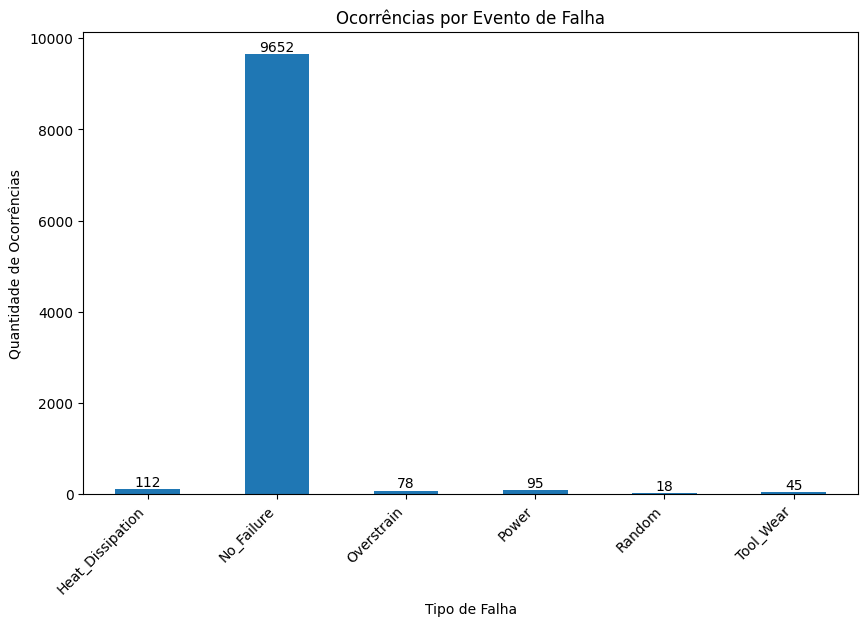

In [31]:
# Contar a quantidade de ocorrências por evento de falha
failure_counts = y_raw.sum()

# Plotar a visualização
plt.figure(figsize=(10, 6))
ax = failure_counts.plot(kind='bar')
plt.title('Ocorrências por Evento de Falha')
plt.xlabel('Tipo de Falha')
plt.ylabel('Quantidade de Ocorrências')
plt.xticks(rotation=45, ha='right')

# Adicionar os números de quantidade por falha acima das barras
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.show()

* Uma solução para superar essas limitações é gerar novos exemplos sintetizados a partir da classe minoritária existente. Esse método é conhecido como Técnica de Superamostragem da Minoria Sintética (SMOTE). Existem muitas variações do SMOTE, mas neste artigo será explicado o método SMOTE-Tomek Links e sua implementação em Python. Esse método combina a superamostragem do SMOTE com a subamostragem dos Tomek Links.

* O método SMOTE-Tomek Links, desenvolvido por Chawla et al. (2002) é uma combinação de técnicas que visa equilibrar os dados ao aumentar a representatividade da classe minoritária através da criação de novos exemplos sintéticos e ao mesmo tempo remover exemplos que são considerados ruidosos ou redundantes na classe majoritária. A implementação desta abordagem utilizando Python é apresentada, detalhando os passos e a lógica do algoritmo, assim como os resultados obtidos em diferentes conjuntos de dados desequilibrados.

* A combinação das técnicas de superamostragem e subamostragem, especificamente utilizando o método SMOTE-Tomek Links, mostra-se eficaz na melhoria do desempenho dos modelos de classificação em conjuntos de dados desequilibrados. Esta abordagem permite ao modelo aprender de forma mais eficiente a partir da classe minoritária, mantendo a integridade e a diversidade da informação no conjunto de dados.



In [32]:
#implementação do método SMOTE no conunto de dados


smt=SMOTETomek(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_raw, y_raw.values)

#normalizar features entre '0 e 1'
scaler01 = MinMaxScaler()
X_res_01 = scaler01.fit_transform(X_resampled)
joblib.dump(scaler01, 'minmax_scaler_01.pkl')  

#normalizar features entre '-1 e 1'
scaler11 = MinMaxScaler(feature_range=(-1, 1))
X_res_11 = scaler11.fit_transform(X_resampled)
joblib.dump(scaler11, 'minmax_scaler_11.pkl')  

# Convertendo para dataframe do pandas
# Converter de volta para DataFrame

#conjunto dados normalizados entre ' 0 e 1'
X_res01_df = pd.DataFrame(X_res_01, columns=features)
y_res01_df = pd.DataFrame(y_resampled, columns=['Heat_Dissipation', 'No_Failure', 'Overstrain', 'Power', 'Random', 'Tool_Wear'])

#conjunto dados normalizados entre ' -1 e 1'
X_res11_df = pd.DataFrame(X_res_11, columns=features)
y_res11_df = pd.DataFrame(y_resampled, columns=['Heat_Dissipation', 'No_Failure', 'Overstrain', 'Power', 'Random', 'Tool_Wear'])

#print(f'O formato de cada conjunto de dados será: X = {X_res01_df.shape } e y= {y_res01_df.shape}')


In [ ]:
# Contar a quantidade de ocorrências por evento de falha
failure_counts = y_res01_df.sum()

# Plotar a visualização
plt.figure(figsize=(10, 6))
ax = failure_counts.plot(kind='bar')
plt.title('Ocorrências por Evento de Falha')
plt.xlabel('Tipo de Falha')
plt.ylabel('Quantidade de Ocorrências')
plt.xticks(rotation=45, ha='right')

# Adicionar os números de quantidade por falha acima das barras
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.show()

* Metodo para normalização do conjunto de dados e formatação para as diferentes redes neurais (MLP e KAN)

In [39]:
def load_Preditive_Maintenance_Dataset(X,y,scaler):
    
    data_min = scaler.data_min_
    data_max = scaler.data_max_
    feature_range_min, feature_range_max = scaler.feature_range  

    #convertendo os dados em tensores e atribuindo a sua excucção na CPU ou GPU (device) conforme disponibilidade avaliada no inicio do programa
    X_ = torch.tensor(X.values, dtype = torch.float32).to(device)
    y_ = torch.tensor(y.values, dtype = torch.float32).to(device)  

    #separa os dados entre conjunto de dados para treinamento (80%) e conjunto de dados para teste/validação (20% <-> teste_size=0.2)
    train_data_, test_data_, train_target_, test_target_ = train_test_split(X_, y_, test_size=0.2, random_state=42)   
    print(train_data_.size()) 

    # geração de  mini batches para melhorar desempenho do treinamento
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data_, train_target_), batch_size=32, shuffle=True)   
    validation_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data_, test_target_), batch_size=32, shuffle=False)  

    #conjunto de dados no formato a ser utilizado no redes MLP
    train_data_loader   = train_loader
    test_data_loader    = validation_loader

    train_data      = train_data_    
    test_data       = test_data_
    train_labels    = train_target_
    test_label      = test_target_
    data_min_scaler = data_min
    data_max_scaler = data_max
    feature_range_min_scaler = feature_range_min
    feature_range_max_scaler = feature_range_max

    MLP_dataset     = [ train_data,
                        train_labels,
                        test_data,
                        test_label,
                        train_data_loader,
                        test_data_loader,
                        data_min_scaler,
                        data_max_scaler,
                        feature_range_min_scaler,
                        feature_range_max_scaler ]  

    return MLP_dataset


In [42]:
dataset01 =load_Preditive_Maintenance_Dataset(X_res01_df,y_res01_df,scaler01)
dataset11 =load_Preditive_Maintenance_Dataset(X_res11_df,y_res01_df,scaler11)
dataset=[dataset01,dataset11]

print(dataset01[0].size())
print(dataset01[1].size())

torch.Size([46294, 7])
torch.Size([46294, 7])
torch.Size([46294, 7])
torch.Size([46294, 6])


In [36]:
# try classification
#X, y = make_classification(n_samples=1000, n_features=4, n_informative=2)
model = imodelsx.KANClassifier(hidden_layer_sizes=[64,32], device=device,
                               regularize_activation=1.0, regularize_entropy=1.0)


In [ ]:
X_array =  X_res01_df.to_numpy()
y_array =  y_res01_df.to_numpy()


model.fit(X_array, y_array)
y_pred = model.predict(X_array)
pred_probas = model.predict_proba(X)
print('Train acc', accuracy_score(y, y_pred))